## Summary
This project involves implementing the Sessa Empirical Estimator (SEE) for estimating prescription durations in a pharmacoepidemiological context. Originally written in R, the SEE will be ported to Python, and applied to a chosen dataset. The standard SEE approach uses K-Means clustering to group similar prescription intervals, but this project will also explore an alternative clustering algorithm to see if it produces different insights. Finally, the results and performance from both clustering methods will be compared, highlighting any differences in exposure classification or prescription duration estimates.

## Objective

#### 1. Replicate the SEE Methodology:
- Convert the SEE R code into Python and validate its functionality on a dataset.
- Implement K-Means clustering to estimate prescription durations and identify exposure windows.

#### 2. Explore an Alternative Clustering Algorithm:
- Substitute K-Means with a different clustering approach (e.g., DBSCAN, Hierarchical Clustering, or GMM).
- Compare the resulting clusters, prescription durations, and exposure periods to those from K-Means.

#### 3. Evaluate and Compare Results:
- Generate metrics and visualizations to illustrate how each clustering algorithm performs.
- Discuss strengths, weaknesses, and potential applications of each approach.

#### 4. Document Findings and Insights:
- Summarize the differences in performance and outcomes between K-Means-based SEE and the alternative method.
- Provide clear recommendations on how clustering choice can affect pharmacoepidemiological analyses.

___

# Process


In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples


### Data Acquisition & Preparation

1. First, we simulate a dataset based on the link provided, ensuring that the dataset has "prescription-like" intervals.

In [2]:
random.seed(42)
np.random.seed(42)

n_patients = 1000
obs_period = 720
start_date = datetime(2020,1,1)
ATC_code = "ABC123"

groups = np.random.choice([1,2,3,4,5,6], size=n_patients,
                          p=[0.1,0.2,0.2,0.2,0.2,0.1])

def simulate_patient(pid, group, start_date, obs_days):
    rows = []
    current_date = start_date
    # initial 30-day supply
    duration = 30
    rows.append({
        "pnr": pid,
        "eksd": current_date,
        "perday": 1,
        "ATC": ATC_code,
        "dur_original": duration
    })
    refill_idx = 1
    end_date = start_date + timedelta(days=obs_days)

    while True:
        if group == 1:
            delay = 0
        elif group == 2:
            delay = random.randint(0,30)
        elif group == 3:
            delay = refill_idx * 5
        elif group == 4:
            delay = 0 if (refill_idx % 2 == 0) else 15
        elif group == 5:
            delay = 0 if (refill_idx <=3) else 60
        elif group == 6:
            if refill_idx>1: break
            delay = 0
        else:
            delay = 0
        duration = int(np.random.choice([30,60,90]))
        next_fill = current_date + timedelta(days=duration+delay)
        if next_fill > end_date:
            break
        rows.append({
            "pnr": pid,
            "eksd": next_fill,
            "perday": 1,
            "ATC": ATC_code,
            "dur_original": duration
        })
        current_date = next_fill
        refill_idx +=1

    return rows

all_rows = []
for i in range(n_patients):
    pat_id = i+1
    grp = groups[i]
    sim = simulate_patient(pat_id, grp, start_date, obs_period)
    all_rows.extend(sim)

sim_df = pd.DataFrame(all_rows)
sim_df["eksd"] = pd.to_datetime(sim_df["eksd"])  # keep datetime

print("Simulated data shape:", sim_df.shape)
print(sim_df)


Simulated data shape: (9316, 5)
       pnr       eksd  perday     ATC  dur_original
0        1 2020-01-01       1  ABC123            30
1        1 2020-04-05       1  ABC123            90
2        1 2020-06-14       1  ABC123            60
3        1 2020-09-27       1  ABC123            90
4        1 2021-01-15       1  ABC123            90
...    ...        ...     ...     ...           ...
9311  1000 2020-11-11       1  ABC123            30
9312  1000 2021-01-10       1  ABC123            30
9313  1000 2021-04-15       1  ABC123            60
9314  1000 2021-07-24       1  ABC123            60
9315  1000 2021-12-06       1  ABC123            90

[9316 rows x 5 columns]


## Silhouette Plotting Function

In [3]:

def plot_silhouette(X, labels):
    sil_vals = silhouette_samples(X, labels)
    avg_sil = np.mean(sil_vals)
    clusters = np.unique(labels)
    y_lower = 10

    plt.figure(figsize=(7,5))
    for c in clusters:
        c_sil = np.sort(sil_vals[labels == c])
        y_upper = y_lower + len(c_sil)
        color = sns.color_palette("hls", len(clusters))[c]
        plt.barh(range(y_lower, y_upper), c_sil, height=1.0, color=color)
        plt.text(-0.05, (y_lower+y_upper)/2, str(c))
        y_lower = y_upper + 10
    plt.axvline(avg_sil, color="red", linestyle="--")
    plt.title("Silhouette Plot")
    plt.xlabel("Coefficient")
    plt.ylabel("Cluster")
    plt.show()


## R -> Python Code (SEE Implementation)

In [5]:
def see_estimator(df, atc):
    # filter
    dff = df[df["ATC"]==atc].copy()
    if dff.empty:
        print(f"No rows for {atc}")
        df["Median"] = np.nan
        return df

    dff.sort_values(["pnr","eksd"], inplace=True)
    dff["prev_eksd"] = dff.groupby("pnr")["eksd"].shift(1)
    dff.dropna(subset=["prev_eksd"], inplace=True)
    if dff.empty:
        print("No consecutive refills.")
        df["Median"] = np.nan
        return df

    dff["event_interval"] = (dff["eksd"] - dff["prev_eksd"]) / pd.Timedelta(days=1)

    # random pick of 1 row per pnr
    def pick_rand(g):
        return g.sample(n=1)

    dff2 = dff.groupby("pnr", group_keys=False).apply(pick_rand)

    # 80% cutoff
    p80 = np.percentile(dff2["event_interval"], 80)
    dff3 = dff2[dff2["event_interval"] <= p80].copy()
    if dff3.empty:
        print("After 80% removal, empty.")
        df["Median"] = np.nan
        return df

    X = dff3[["event_interval"]].values

    # find best k using silhouette
    best_k=2
    best_sil=-1
    for k in range(2,8):
        kmtemp=KMeans(n_clusters=k, random_state=42)
        labs=kmtemp.fit_predict(X)
        sil=silhouette_score(X, labs)
        if sil>best_sil:
            best_sil=sil
            best_k=k

    print(f"Best k={best_k} with sil={best_sil:.3f}")
    final_km=KMeans(n_clusters=best_k, random_state=42)
    final_labs=final_km.fit_predict(X)
    dff3["cluster"] = final_labs

    # optional plot
    print("Plotting silhouette...")
    plot_silhouette(X, final_labs)

    # compute median durations
    dff3["log_interval"] = np.log(dff3["event_interval"].clip(lower=1e-9))
    meds = dff3.groupby("cluster")["log_interval"].median().reset_index()
    meds.columns=["cluster","median_log"]
    meds["median_duration"] = np.exp(meds["median_log"])

    dff3 = dff3.merge(meds, on="cluster", how="left")
    dff3["Median"] = dff3["median_duration"]

    # fallback to main cluster
    freq = dff3["cluster"].value_counts()
    main_c = freq.idxmax()
    main_m = meds.loc[meds["cluster"]==main_c, "median_duration"].values[0]

    dff2_merged = dff2.merge(
        dff3[["pnr","eksd","Median"]],
        on=["pnr","eksd"], how="left"
    )
    dff2_merged["Median"] = dff2_merged["Median"].fillna(main_m)

    # final merge
    df_final = df.merge(
        dff2_merged[["pnr","Median"]],
        on="pnr", how="left"
    )

    df_final["Median"] = df_final["Median"].fillna(main_m)

    return df_final

## Code Run

C:\Users\Aris\AppData\Local\Temp\ipykernel_16052\1220174109.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dff2 = dff.groupby("pnr", group_keys=False).apply(pick_rand)


Best k=6 with sil=0.810
Plotting silhouette...


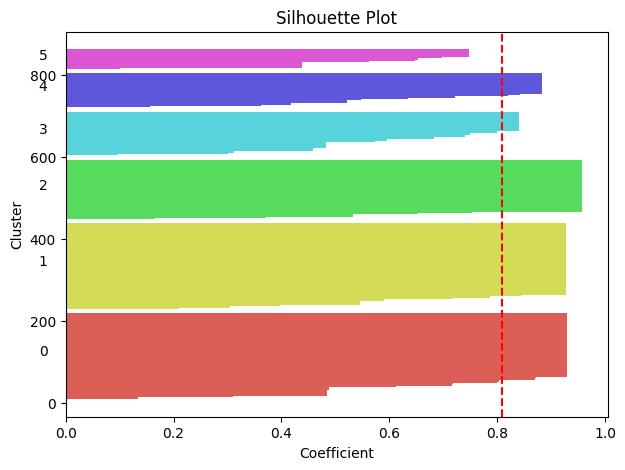

(9316, 6)
   pnr       eksd  perday     ATC  dur_original  Median
0    1 2020-01-01       1  ABC123            30    60.0
1    1 2020-04-05       1  ABC123            90    60.0
2    1 2020-06-14       1  ABC123            60    60.0
3    1 2020-09-27       1  ABC123            90    60.0
4    1 2021-01-15       1  ABC123            90    60.0
5    1 2021-03-11       1  ABC123            30    60.0
6    1 2021-05-10       1  ABC123            30    60.0
7    1 2021-09-12       1  ABC123            90    60.0
8    1 2021-11-21       1  ABC123            30    60.0
9    2 2020-01-01       1  ABC123            30    60.0


In [6]:
if __name__=="__main__":
    final = see_estimator(sim_df, "ABC123")
    print(final.shape)
    print(final.head(10))